In [1]:
pip install polars

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import polars as pl
import os
import json
import requests
import io
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


In [3]:
import requests

user_video_df = pl.read_ndjson("/kaggle/input/lightmooccubex/relations/user-video.json")
user_video_df.head()


seq,user_id
list[struct[2]],str
"[{""V_1395633"",[{130.0,190.0,1.0,1588431144}, {220.0,250.0,1.0,1588431234}, … {655.1,692.55,1.25,1588437514}]}, {""V_1395635"",[{135.0,170.0,1.0,1588438045}]}, … {""V_6210800"",[{6.0,13.5,1.5,1601012899}]}]","""U_112"""
"[{""V_6224262"",[{286.0,506.0,2.0,1604061626}]}]","""U_150"""
"[{""V_6432959"",[{4552.1,4556.8,1.0,1598192594}]}]","""U_172"""
"[{""V_6334508"",[{4.0,109.0,1.0,1598832781}, {119.0,254.0,1.0,1598832896}]}, {""V_6334516"",[{593.0,598.0,1.0,1598834837}]}, … {""V_6254676"",[{5.0,105.0,1.0,1603849805}]}]","""U_189"""
"[{""V_1358540"",[{59.747,64.747,1.0,1582184174}, {69.795,74.795,1.0,1582184184}, … {584.751,589.751,1.0,1582186212}]}, {""V_1358542"",[{124.588,129.588,1.0,1582186455}, {194.608,199.608,1.0,1582186525}, … {579.763,584.763,1.0,1582186910}]}, … {""V_1358782"",[{350.2,395.3,1.5,1587530324}, {492.6,95.4,1.5,1587530419}]}]","""U_197"""


In [4]:
user_video_df.schema

Schema([('seq',
         List(Struct({'video_id': String, 'segment': List(Struct({'start_point': Float64, 'end_point': Float64, 'speed': Float64, 'local_start_time': Int64}))}))),
        ('user_id', String)])

In [5]:
### Bước 1: Làm phẳng dữ liệu lồng ghép

# Mở rộng cột 'seq' để mỗi hàng là một user_id - video_id duy nhất
# Sau bước này, mỗi hàng sẽ là một cặp user_id và một struct chứa video_id và list segment của nó
video_expanded_df = user_video_df.explode("seq")

# Tách 'video_id' và 'segment' từ cột 'seq'
video_details_df = video_expanded_df.with_columns(
    pl.col("seq").struct.field("video_id").alias("video_id"),
    pl.col("seq").struct.field("segment").alias("segments_list")
).drop("seq") # Xóa cột 'seq' gốc sau khi đã tách

# Mở rộng cột 'segments_list' để mỗi hàng là một tương tác (segment) duy nhất
final_flat_df = video_details_df.explode("segments_list")

# Tách các trường từ mỗi segment (start_point, end_point, speed, local_start_time)
final_flat_df = final_flat_df.with_columns(
    pl.col("segments_list").struct.field("start_point").alias("start_point"),
    pl.col("segments_list").struct.field("end_point").alias("end_point"),
    pl.col("segments_list").struct.field("speed").alias("playback_speed"),
    pl.col("segments_list").struct.field("local_start_time").alias("timestamp")
).drop("segments_list") # Xóa cột 'segments_list' gốc

# Chuyển đổi timestamp sang định dạng datetime
final_flat_df = final_flat_df.with_columns(
    pl.from_epoch("timestamp", time_unit="s").alias("datetime")
)

print("\n--- DataFrame cuối cùng đã được làm phẳng (final_flat_df) ---")
print(final_flat_df.head())
print(final_flat_df.schema)
print(final_flat_df.describe())


--- DataFrame cuối cùng đã được làm phẳng (final_flat_df) ---
shape: (5, 7)
┌─────────┬───────────┬─────────────┬───────────┬────────────────┬────────────┬──────────────┐
│ user_id ┆ video_id  ┆ start_point ┆ end_point ┆ playback_speed ┆ timestamp  ┆ datetime     │
│ ---     ┆ ---       ┆ ---         ┆ ---       ┆ ---            ┆ ---        ┆ ---          │
│ str     ┆ str       ┆ f64         ┆ f64       ┆ f64            ┆ i64        ┆ datetime[μs] │
╞═════════╪═══════════╪═════════════╪═══════════╪════════════════╪════════════╪══════════════╡
│ U_112   ┆ V_1395633 ┆ 130.0       ┆ 190.0     ┆ 1.0            ┆ 1588431144 ┆ 2020-05-02   │
│         ┆           ┆             ┆           ┆                ┆            ┆ 14:52:24     │
│ U_112   ┆ V_1395633 ┆ 220.0       ┆ 250.0     ┆ 1.0            ┆ 1588431234 ┆ 2020-05-02   │
│         ┆           ┆             ┆           ┆                ┆            ┆ 14:53:54     │
│ U_112   ┆ V_1395633 ┆ 478.8       ┆ 508.8     ┆ 1.0            ┆ 1

In [6]:
# 1. Tổng số người dùng và video duy nhất
print(f"\nTổng số người dùng duy nhất: {final_flat_df['user_id'].n_unique()}")
print(f"Tổng số video duy nhất: {final_flat_df['video_id'].n_unique()}")


Tổng số người dùng duy nhất: 310360
Tổng số video duy nhất: 193624


In [7]:
# 2. Tổng số tương tác xem video
print(f"Tổng số lượt tương tác xem video: {final_flat_df.height}")


Tổng số lượt tương tác xem video: 25748664



Tổng số người dùng duy nhất: 310360
Tổng số video duy nhất: 193624
Tổng số lượt tương tác xem video: 25748664


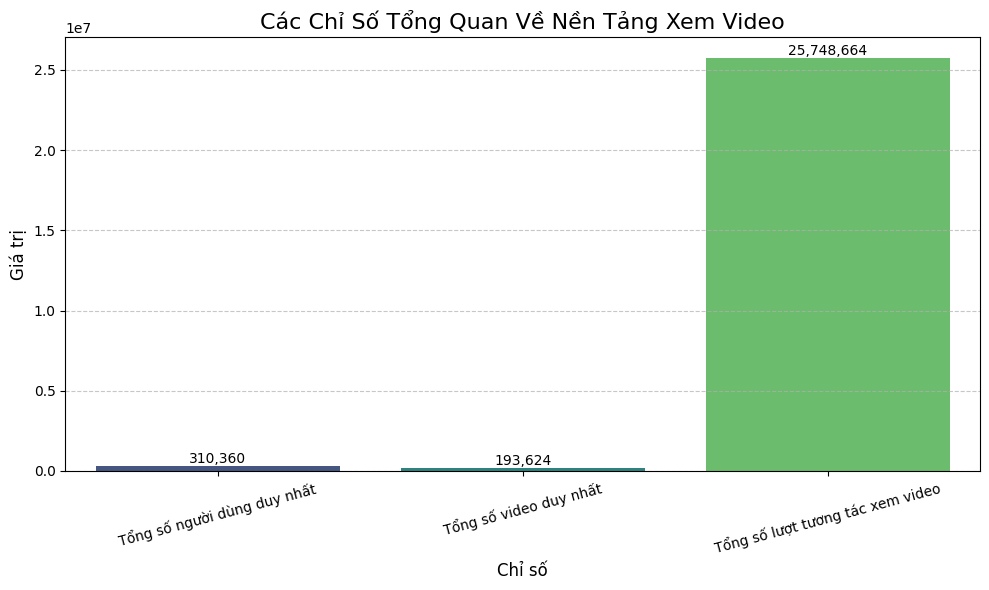

In [43]:
# --- Tính toán các chỉ số từ final_flat_df ---
total_unique_users = final_flat_df['user_id'].n_unique()
total_unique_videos = final_flat_df['video_id'].n_unique()
total_interactions = final_flat_df.height

# In ra để xác nhận
print(f"\nTổng số người dùng duy nhất: {total_unique_users}")
print(f"Tổng số video duy nhất: {total_unique_videos}")
print(f"Tổng số lượt tương tác xem video: {total_interactions}")

## Biểu đồ Thể hiện Các Chỉ Số Tổng Quan

# Tạo DataFrame từ các giá trị đã tính toán
stats_data = {
    'Chỉ số': [
        'Tổng số người dùng duy nhất',
        'Tổng số video duy nhất',
        'Tổng số lượt tương tác xem video'
    ],
    'Giá trị': [
        total_unique_users,
        total_unique_videos,
        total_interactions
    ]
}

stats_df = pd.DataFrame(stats_data)

plt.figure(figsize=(10, 6))
# Sử dụng sns.barplot để tạo biểu đồ cột
sns.barplot(x='Chỉ số', y='Giá trị', data=stats_df, palette='viridis') # 'viridis' là một color palette khác đẹp

# Thêm nhãn giá trị lên trên mỗi cột để dễ đọc
for index, row in stats_df.iterrows():
    plt.text(index, row['Giá trị'], f'{row["Giá trị"]:,.0f}', color='black', ha="center", va='bottom', fontsize=10)

plt.title("Các Chỉ Số Tổng Quan Về Nền Tảng Xem Video", fontsize=16)
plt.xlabel("Chỉ số", fontsize=12)
plt.ylabel("Giá trị", fontsize=12)
plt.xticks(rotation=15) # Xoay nhẹ nhãn trục X để tránh chồng chéo
plt.grid(axis='y', linestyle='--', alpha=0.7) # Thêm lưới ngang cho dễ đọc
plt.tight_layout() # Điều chỉnh bố cục để tránh cắt xén nhãn
plt.show()

In [8]:
# 3. Tính toán thời lượng xem cho mỗi segment (giả định đơn vị là giây)
df_with_duration = final_flat_df.with_columns(
    (pl.col("end_point") - pl.col("start_point")).alias("segment_duration_seconds")
)
print("\nDataFrame với cột 'segment_duration_seconds' (top 5):")
print(df_with_duration.head())



DataFrame với cột 'segment_duration_seconds' (top 5):
shape: (5, 8)
┌─────────┬───────────┬────────────┬───────────┬────────────┬────────────┬────────────┬────────────┐
│ user_id ┆ video_id  ┆ start_poin ┆ end_point ┆ playback_s ┆ timestamp  ┆ datetime   ┆ segment_du │
│ ---     ┆ ---       ┆ t          ┆ ---       ┆ peed       ┆ ---        ┆ ---        ┆ ration_sec │
│ str     ┆ str       ┆ ---        ┆ f64       ┆ ---        ┆ i64        ┆ datetime[μ ┆ onds       │
│         ┆           ┆ f64        ┆           ┆ f64        ┆            ┆ s]         ┆ ---        │
│         ┆           ┆            ┆           ┆            ┆            ┆            ┆ f64        │
╞═════════╪═══════════╪════════════╪═══════════╪════════════╪════════════╪════════════╪════════════╡
│ U_112   ┆ V_1395633 ┆ 130.0      ┆ 190.0     ┆ 1.0        ┆ 1588431144 ┆ 2020-05-02 ┆ 60.0       │
│         ┆           ┆            ┆           ┆            ┆            ┆ 14:52:24   ┆            │
│ U_112   ┆ V_1395633 

In [9]:
# 4. Tổng thời gian xem của mỗi người dùng
total_watch_time_per_user = df_with_duration.group_by("user_id").agg(
    pl.col("segment_duration_seconds").sum().alias("total_watch_time_seconds_per_user")
).sort("total_watch_time_seconds_per_user", descending=True)
print("\nTổng thời gian xem mỗi người dùng (top 5):")
print(total_watch_time_per_user.head())



Tổng thời gian xem mỗi người dùng (top 5):
shape: (5, 2)
┌────────────┬─────────────────────────────────┐
│ user_id    ┆ total_watch_time_seconds_per_u… │
│ ---        ┆ ---                             │
│ str        ┆ f64                             │
╞════════════╪═════════════════════════════════╡
│ U_34007795 ┆ 641972.0                        │
│ U_35198931 ┆ 541749.0                        │
│ U_35198927 ┆ 534415.0                        │
│ U_35199212 ┆ 503368.0                        │
│ U_35197123 ┆ 427699.0                        │
└────────────┴─────────────────────────────────┘


In [10]:
# Làm phẳng DataFrame theo đúng schema mới
video_expanded_df = user_video_df.explode("seq")
video_details_df = video_expanded_df.with_columns(
    pl.col("seq").struct.field("video_id").alias("video_id"),
    pl.col("seq").struct.field("segment").alias("segments_list")
).drop("seq")

final_flat_df = video_details_df.explode("segments_list")
final_flat_df = final_flat_df.with_columns(
    pl.col("segments_list").struct.field("start_point").alias("start_point"),
    pl.col("segments_list").struct.field("end_point").alias("end_point"),
    pl.col("segments_list").struct.field("speed").alias("playback_speed"),
    pl.col("segments_list").struct.field("local_start_time").alias("timestamp")
).drop("segments_list")

final_flat_df = final_flat_df.with_columns(
    pl.from_epoch("timestamp", time_unit="s").alias("datetime"),
    (pl.col("end_point") - pl.col("start_point")).alias("segment_duration_seconds") # Tính duration ngay đây
)

# Chuyển đổi sang Pandas DataFrame để vẽ biểu đồ với Seaborn/Matplotlib
# Chỉ giữ lại các cột cần thiết để tránh lỗi bộ nhớ với DataFrame quá lớn
df_for_plotting = final_flat_df.select([
    "user_id", "video_id", "playback_speed", "segment_duration_seconds", "datetime"
]).to_pandas()

In [19]:
# --- Tính toán các DataFrame tổng hợp cần thiết cho biểu đồ (đã là Pandas DF) ---
total_watch_time_per_user_df = final_flat_df.group_by("user_id").agg(
    pl.col("segment_duration_seconds").sum().alias("total_watch_time_seconds_per_user")
).to_pandas()

total_watch_time_per_video_df = final_flat_df.group_by("video_id").agg(
    pl.col("segment_duration_seconds").sum().alias("total_watch_time_seconds_per_video")
).to_pandas()

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


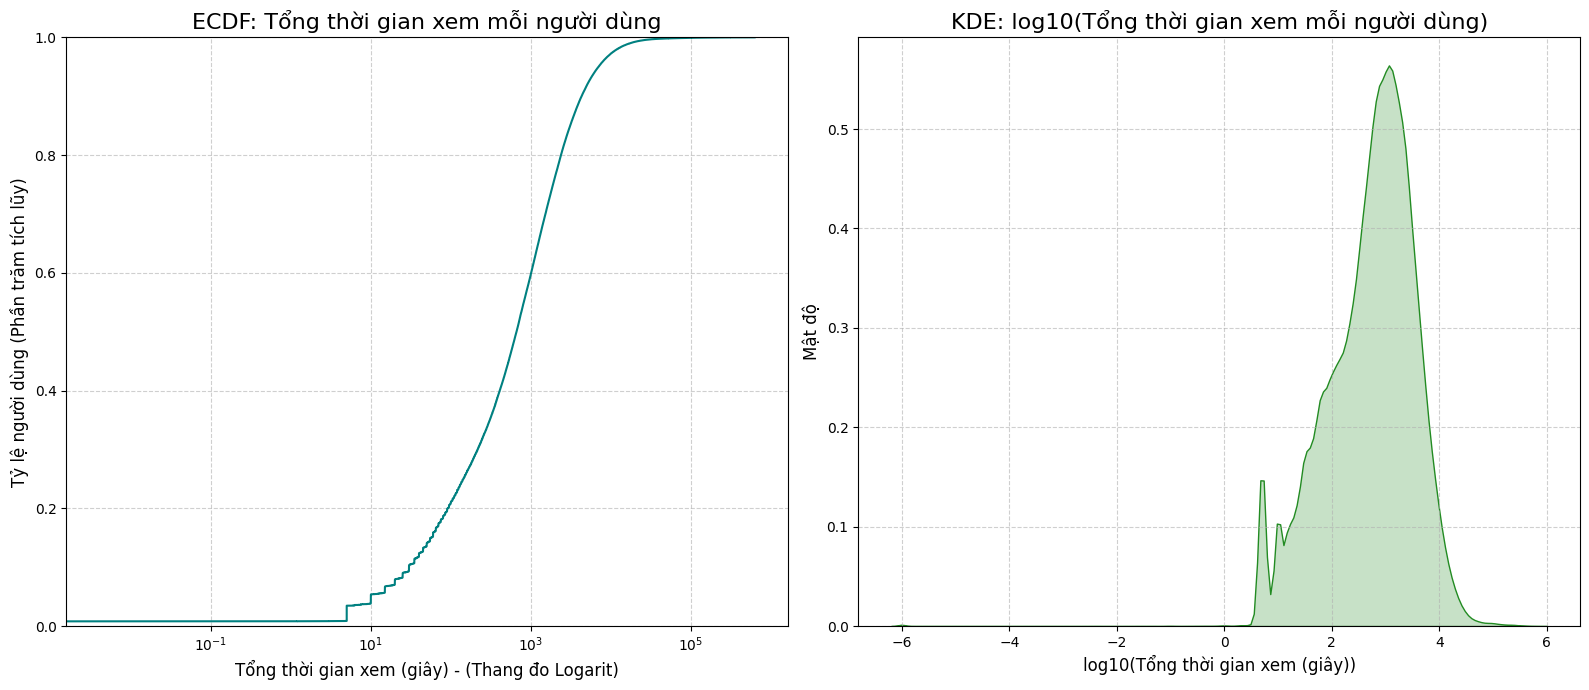

In [21]:
# Để tránh lỗi log(0) nếu có thời gian xem là 0, thêm một epsilon nhỏ
total_watch_time_per_user_df['total_watch_time_seconds_per_user_log'] = \
    np.log10(total_watch_time_per_user_df['total_watch_time_seconds_per_user'] + 1e-6) # + epsilon nhỏ

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Biểu đồ 1: ECDF Plot
sns.ecdfplot(x='total_watch_time_seconds_per_user', data=total_watch_time_per_user_df, ax=axes[0], color='teal')
axes[0].set_title("ECDF: Tổng thời gian xem mỗi người dùng", fontsize=16)
axes[0].set_xlabel("Tổng thời gian xem (giây) - (Thang đo Logarit)", fontsize=12)
axes[0].set_ylabel("Tỷ lệ người dùng (Phần trăm tích lũy)", fontsize=12)
axes[0].set_xscale('log')
axes[0].grid(True, linestyle='--', alpha=0.6)

# Biểu đồ 2: KDE Plot (trên dữ liệu đã log-transform)
sns.kdeplot(x='total_watch_time_seconds_per_user_log', data=total_watch_time_per_user_df, fill=True, ax=axes[1], color='forestgreen')
axes[1].set_title("KDE: log10(Tổng thời gian xem mỗi người dùng)", fontsize=16)
axes[1].set_xlabel("log10(Tổng thời gian xem (giây))", fontsize=12)
axes[1].set_ylabel("Mật độ", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [15]:
# 5. Tổng thời gian xem của mỗi video
total_watch_time_per_video_df = df_with_duration.group_by("video_id").agg(
    pl.col("segment_duration_seconds").sum().alias("total_watch_time_seconds_per_video")
).sort("total_watch_time_seconds_per_video", descending=True)
print("\nTổng thời gian xem mỗi video (top 5):")
print(total_watch_time_per_video.head())



Tổng thời gian xem mỗi video (top 5):
shape: (5, 2)
┌───────────┬─────────────────────────────────┐
│ video_id  ┆ total_watch_time_seconds_per_v… │
│ ---       ┆ ---                             │
│ str       ┆ f64                             │
╞═══════════╪═════════════════════════════════╡
│ V_1395633 ┆ 6.1607e6                        │
│ V_1395641 ┆ 3.7130e6                        │
│ V_1358540 ┆ 2.0535e6                        │
│ V_1358564 ┆ 1.7825e6                        │
│ V_1358544 ┆ 1.6229e6                        │
└───────────┴─────────────────────────────────┘


/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


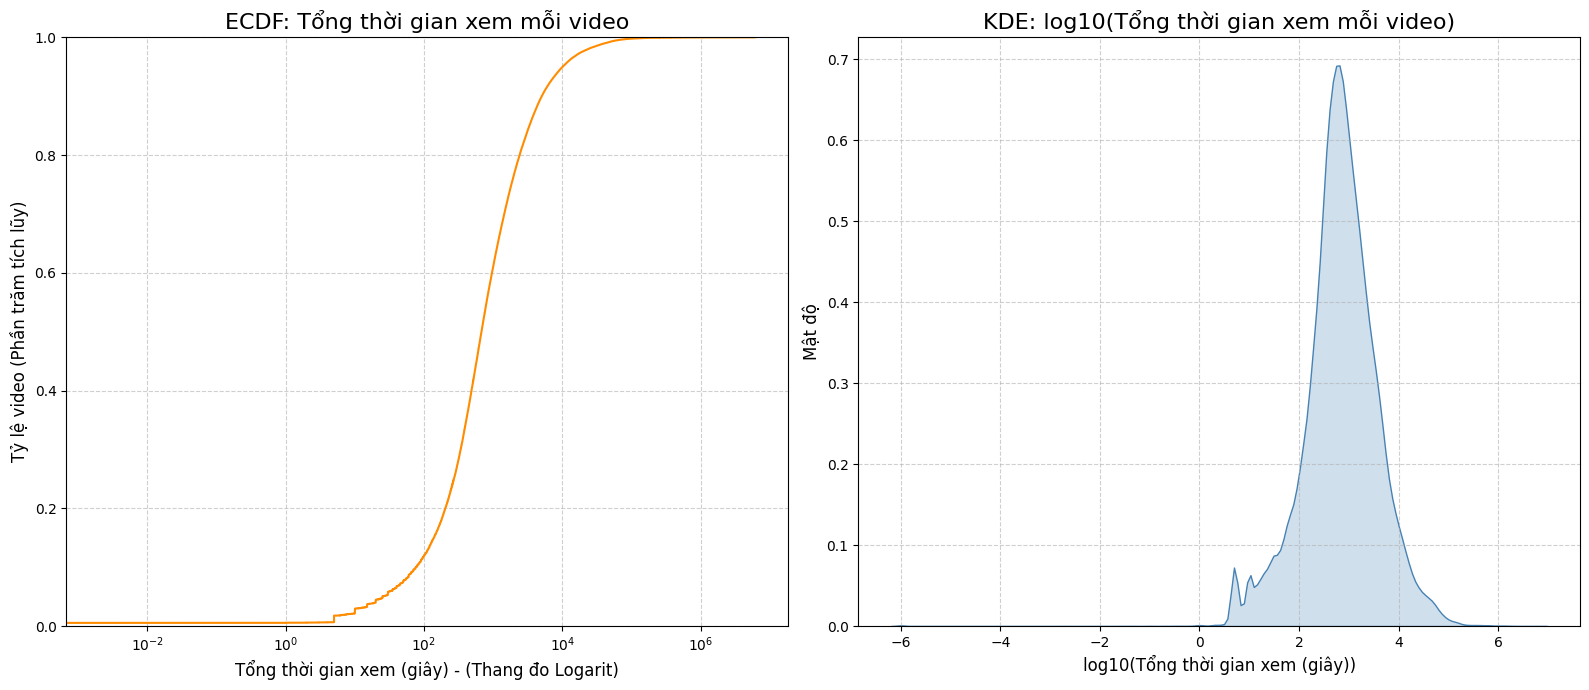

In [20]:
# SỬA LỖI: Tạo cột log-transform trên Pandas DataFrame
# Để tránh lỗi log(0) nếu có thời gian xem là 0, thêm một epsilon nhỏ
total_watch_time_per_video_df['total_watch_time_seconds_per_video_log'] = \
    np.log10(total_watch_time_per_video_df['total_watch_time_seconds_per_video'] + 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Biểu đồ 1: ECDF Plot
sns.ecdfplot(x='total_watch_time_seconds_per_video', data=total_watch_time_per_video_df, ax=axes[0], color='darkorange')
axes[0].set_title("ECDF: Tổng thời gian xem mỗi video", fontsize=16)
axes[0].set_xlabel("Tổng thời gian xem (giây) - (Thang đo Logarit)", fontsize=12)
axes[0].set_ylabel("Tỷ lệ video (Phần trăm tích lũy)", fontsize=12)
axes[0].set_xscale('log') # Áp dụng thang đo logarit cho trục X
axes[0].grid(True, linestyle='--', alpha=0.6)

# Biểu đồ 2: KDE Plot (trên dữ liệu đã log-transform)
sns.kdeplot(x='total_watch_time_seconds_per_video_log', data=total_watch_time_per_video_df, fill=True, ax=axes[1], color='steelblue')
axes[1].set_title("KDE: log10(Tổng thời gian xem mỗi video)", fontsize=16)
axes[1].set_xlabel("log10(Tổng thời gian xem (giây))", fontsize=12)
axes[1].set_ylabel("Mật độ", fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

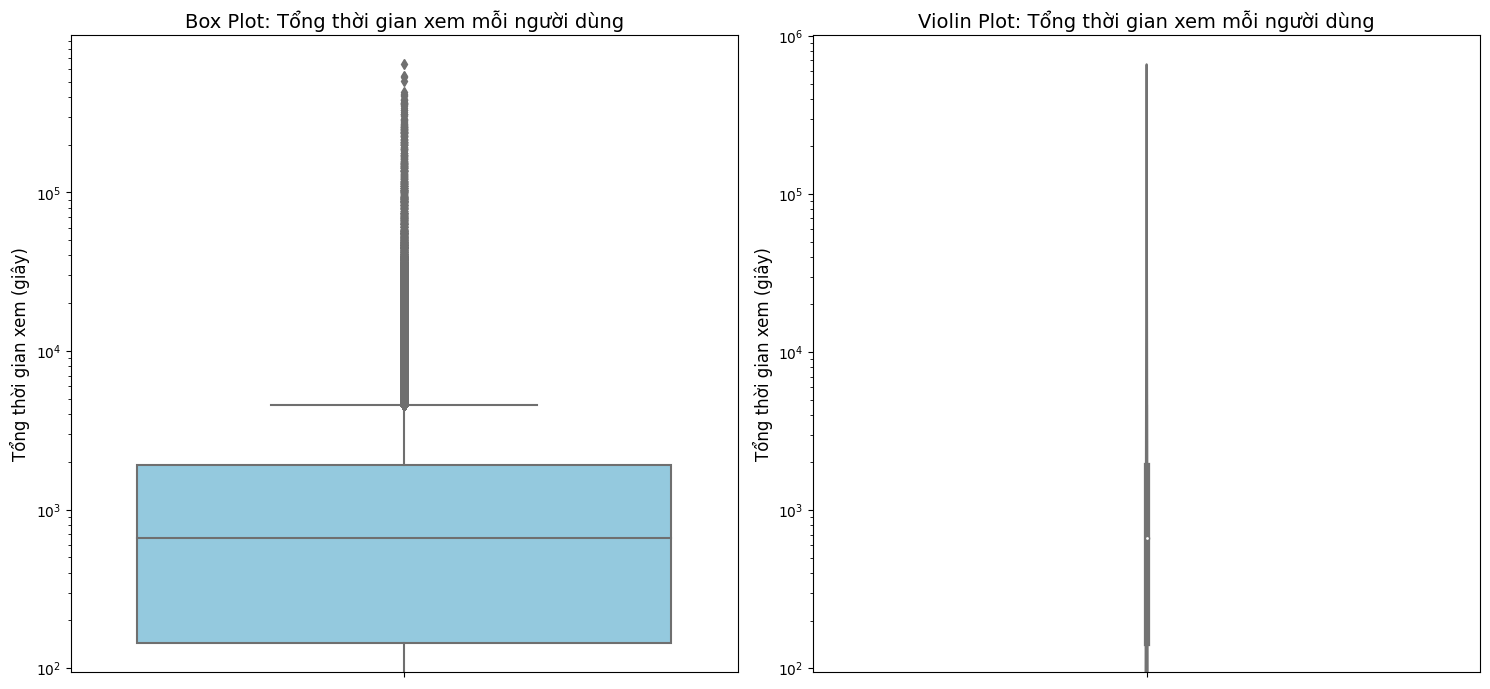

In [22]:
# Tính tổng thời gian xem mỗi người dùng
total_watch_time_per_user_df = final_flat_df.group_by("user_id").agg(
    pl.col("segment_duration_seconds").sum().alias("total_watch_time_seconds_per_user")
).to_pandas()

# Tạo 2 biểu đồ trên cùng một figure
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

# Biểu đồ 1: Box Plot
sns.boxplot(y=total_watch_time_per_user_df['total_watch_time_seconds_per_user'], ax=axes[0], color='skyblue')
axes[0].set_title("Box Plot: Tổng thời gian xem mỗi người dùng", fontsize=14)
axes[0].set_ylabel("Tổng thời gian xem (giây)", fontsize=12)
axes[0].set_yscale('log') # Áp dụng thang đo logarit cho trục Y

# Biểu đồ 2: Violin Plot
sns.violinplot(y=total_watch_time_per_user_df['total_watch_time_seconds_per_user'], ax=axes[1], color='lightgreen')
axes[1].set_title("Violin Plot: Tổng thời gian xem mỗi người dùng", fontsize=14)
axes[1].set_ylabel("Tổng thời gian xem (giây)", fontsize=12)
axes[1].set_yscale('log') # Áp dụng thang đo logarit cho trục Y

plt.tight_layout()
plt.show()

In [24]:
# 6. Phân bố tốc độ phát lại
print("\nPhân bố tốc độ phát lại video:")
playback_speed_dist = final_flat_df.group_by("playback_speed").agg(
    pl.len().alias("num_segments")
).sort("playback_speed")
print(playback_speed_dist)



Phân bố tốc độ phát lại video:
shape: (5, 2)
┌────────────────┬──────────────┐
│ playback_speed ┆ num_segments │
│ ---            ┆ ---          │
│ f64            ┆ u32          │
╞════════════════╪══════════════╡
│ 0.5            ┆ 2560         │
│ 1.0            ┆ 20348286     │
│ 1.25           ┆ 628161       │
│ 1.5            ┆ 722585       │
│ 2.0            ┆ 4047072      │
└────────────────┴──────────────┘


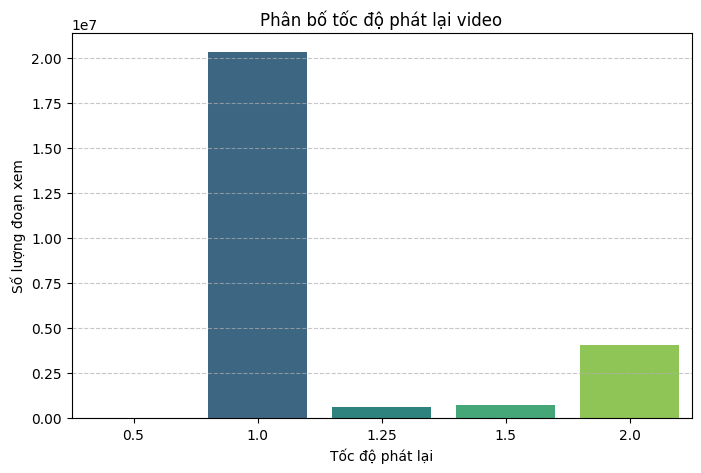

In [25]:
# Tính phân bố tốc độ phát lại
playback_speed_dist_df = final_flat_df.group_by("playback_speed").agg(
    pl.len().alias("num_segments")
).sort("playback_speed").to_pandas() # Chuyển sang pandas để vẽ biểu đồ

plt.figure(figsize=(8, 5))
sns.barplot(x='playback_speed', y='num_segments', data=playback_speed_dist_df, palette='viridis')
plt.title("Phân bố tốc độ phát lại video")
plt.xlabel("Tốc độ phát lại")
plt.ylabel("Số lượng đoạn xem")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [26]:
# 7. Số lượng segment trung bình mỗi video
avg_segments_per_video = final_flat_df.group_by("video_id").agg(
    pl.len().alias("num_segments_in_video")
).select(pl.col("num_segments_in_video").mean().alias("avg_segments_per_video"))
print(f"\nSố lượng segment trung bình mỗi video: {avg_segments_per_video.item()}")



Số lượng segment trung bình mỗi video: 132.98281204809322



Số lượng segment trung bình trên tất cả các video: 132.98


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


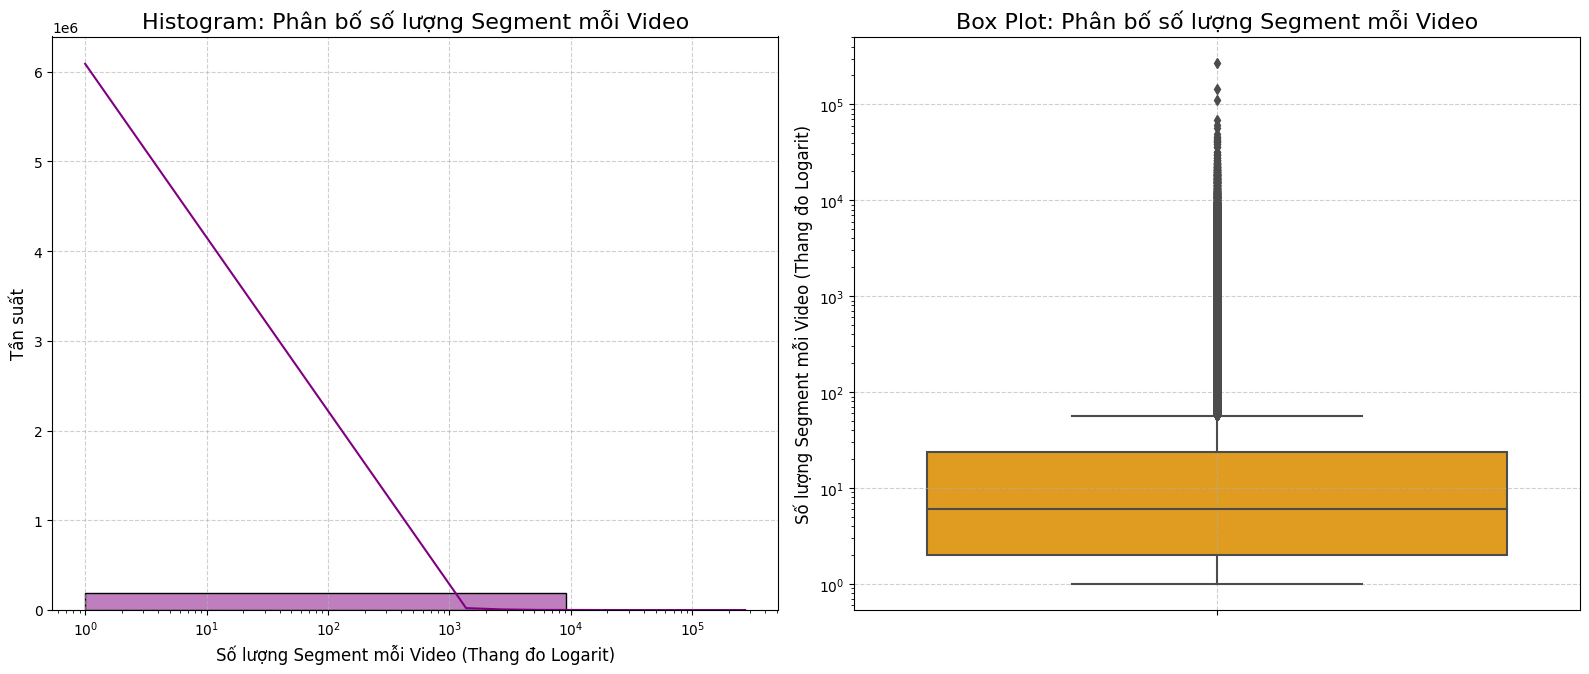

In [45]:
# --- Tính toán số lượng segment cho mỗi video ---
# Đếm số lần xuất hiện của mỗi video_id, mỗi lần xuất hiện là một segment
segment_count_per_video_df = final_flat_df.group_by("video_id").agg(
    pl.len().alias("segment_count_per_video") # len() ở đây đếm số hàng (segment) cho mỗi video_id
).to_pandas()

# Nếu bạn muốn tính "trung bình" của số segment trên *tất cả* các video, bạn sẽ làm như sau:
average_segments_overall = segment_count_per_video_df['segment_count_per_video'].mean()
print(f"\nSố lượng segment trung bình trên tất cả các video: {average_segments_overall:.2f}")


# Để tránh lỗi log(0) nếu có giá trị là 0, thêm một epsilon nhỏ khi log-transform
# Mặc dù số segment thường không phải là 0, nhưng đây là một biện pháp an toàn.
segment_count_per_video_df['segment_count_per_video_log'] = \
    np.log10(segment_count_per_video_df['segment_count_per_video'] + 1e-6)

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

# Biểu đồ 1: Histogram của Số lượng Segment mỗi Video (trên thang đo logarit)
sns.histplot(x='segment_count_per_video', data=segment_count_per_video_df, ax=axes[0], bins=30, kde=True, color='purple')
axes[0].set_title("Histogram: Phân bố số lượng Segment mỗi Video", fontsize=16)
axes[0].set_xlabel("Số lượng Segment mỗi Video (Thang đo Logarit)", fontsize=12)
axes[0].set_ylabel("Tần suất", fontsize=12)
axes[0].set_xscale('log') # Áp dụng thang đo logarit cho trục X
axes[0].grid(True, linestyle='--', alpha=0.6)

# Biểu đồ 2: Box Plot của Số lượng Segment mỗi Video (trên thang đo logarit)
sns.boxplot(y='segment_count_per_video', data=segment_count_per_video_df, ax=axes[1], color='orange')
axes[1].set_title("Box Plot: Phân bố số lượng Segment mỗi Video", fontsize=16)
axes[1].set_ylabel("Số lượng Segment mỗi Video (Thang đo Logarit)", fontsize=12)
axes[1].set_yscale('log') # Áp dụng thang đo logarit cho trục Y
axes[1].grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
plt.show()

In [28]:
# 8. Hoạt động xem video theo thời gian (ví dụ: theo ngày)
df_by_day = final_flat_df.with_columns(
    pl.col("datetime").dt.date().alias("view_date")
)
daily_views = df_by_day.group_by("view_date").agg(
    pl.len().alias("total_views")
).sort("view_date")
print("\nTổng số lượt xem theo ngày (top 5):")
print(daily_views.head())



Tổng số lượt xem theo ngày (top 5):
shape: (5, 2)
┌────────────┬─────────────┐
│ view_date  ┆ total_views │
│ ---        ┆ ---         │
│ date       ┆ u32         │
╞════════════╪═════════════╡
│ 2001-12-31 ┆ 14          │
│ 2006-06-30 ┆ 11          │
│ 2006-07-01 ┆ 17          │
│ 2008-12-31 ┆ 7           │
│ 2009-12-31 ┆ 3           │
└────────────┴─────────────┘


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


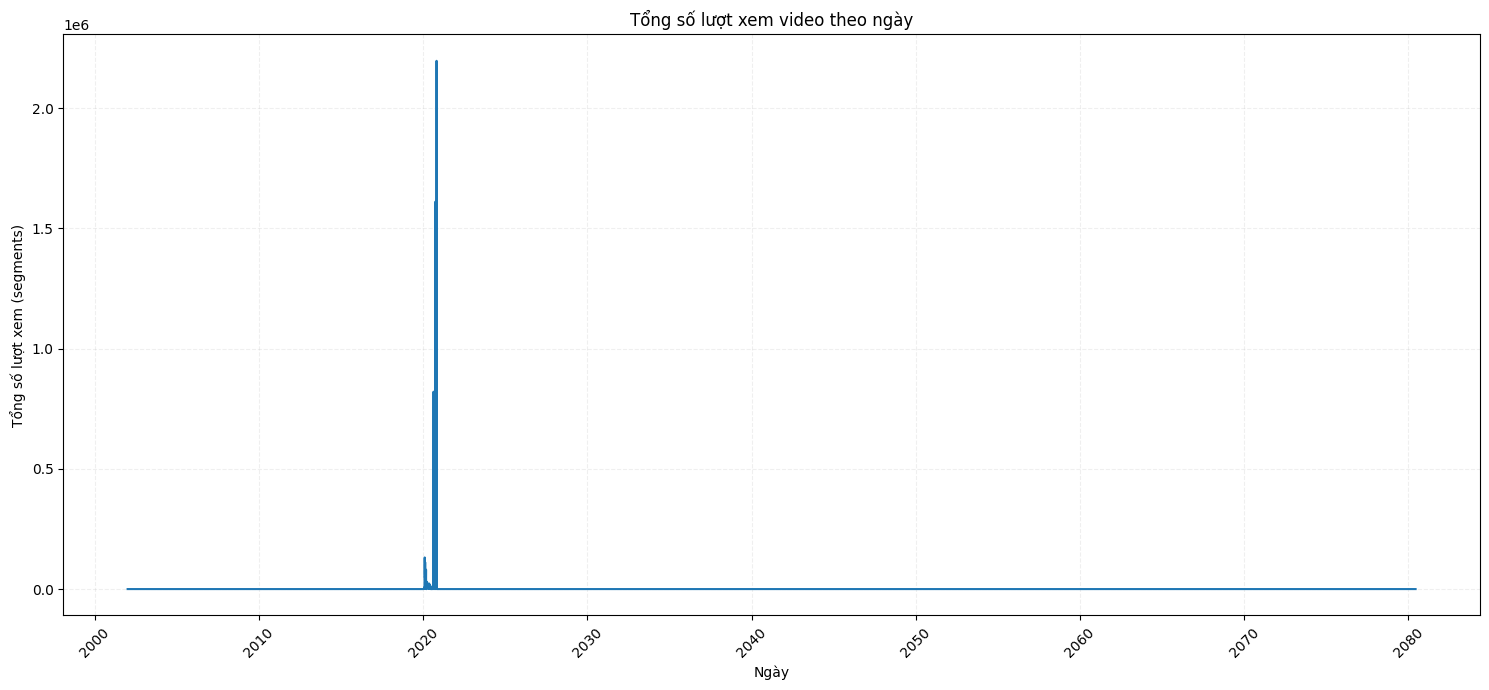

In [39]:
# Xác định khoảng thời gian bạn muốn xem
start_date = '2015-01-01'
end_date = '2025-12-31'

# Lọc DataFrame để chỉ giữ lại dữ liệu trong khoảng thời gian mong muốn
filtered_daily_views_df = daily_views_df[
    (daily_views_df['view_date'] >= start_date) &
    (daily_views_df['view_date'] <= end_date)
].copy() # Sử dụng .copy() để tránh SettingWithCopyWarning

plt.figure(figsize=(15, 7))
sns.lineplot(x='view_date', y='total_views', data=filtered_daily_views_df, marker='o', linestyle='-', color='purple', linewidth=1.5, markersize=4)
plt.title(f"Tổng số lượt xem video theo ngày ({start_date} đến {end_date})", fontsize=16)
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Tổng số lượt xem (segments)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


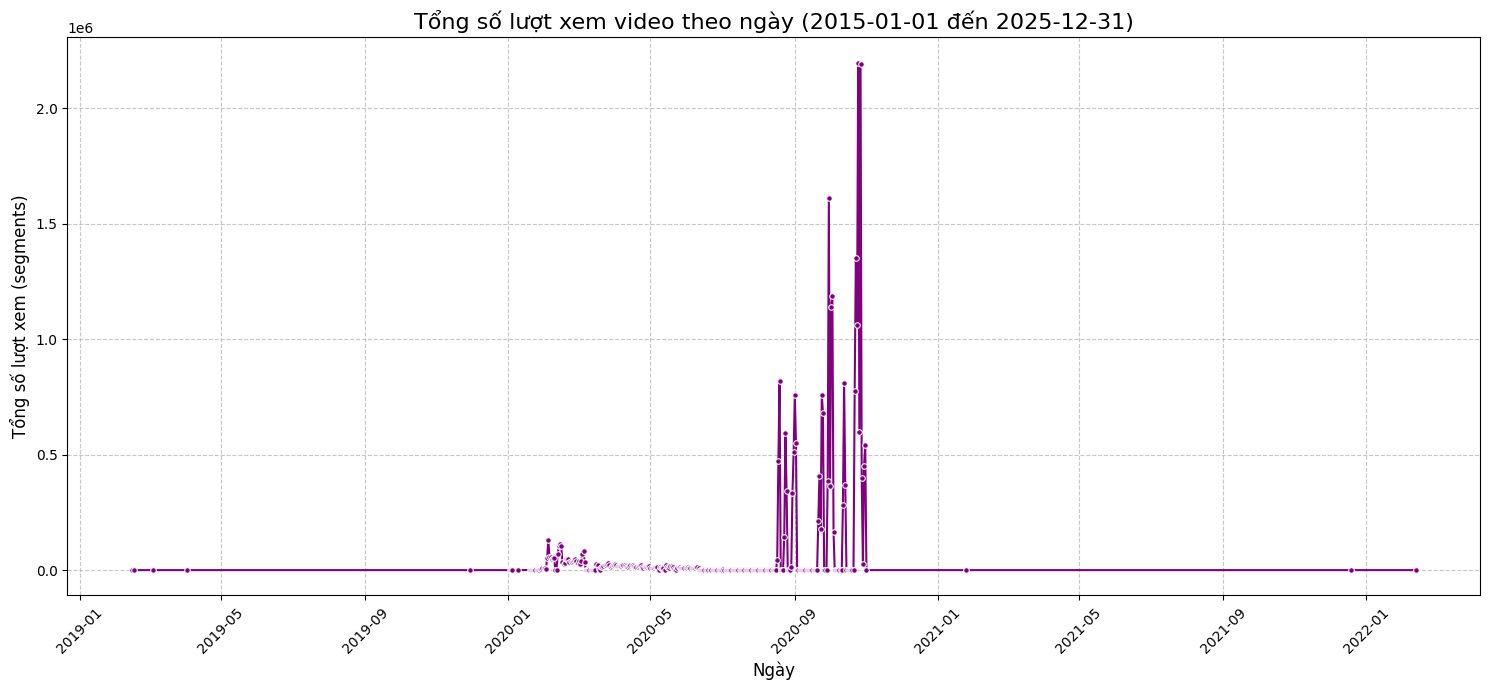

In [40]:
# Xác định khoảng thời gian bạn muốn xem
start_date = '2015-01-01'
end_date = '2025-12-31'

# Lọc DataFrame để chỉ giữ lại dữ liệu trong khoảng thời gian mong muốn
filtered_daily_views_df = daily_views_df[
    (daily_views_df['view_date'] >= start_date) &
    (daily_views_df['view_date'] <= end_date)
].copy() # Sử dụng .copy() để tránh SettingWithCopyWarning

plt.figure(figsize=(15, 7))
sns.lineplot(x='view_date', y='total_views', data=filtered_daily_views_df, marker='o', linestyle='-', color='purple', linewidth=1.5, markersize=4)
plt.title(f"Tổng số lượt xem video theo ngày ({start_date} đến {end_date})", fontsize=16)
plt.xlabel("Ngày", fontsize=12)
plt.ylabel("Tổng số lượt xem (segments)", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [32]:
# 9. Video nào được xem nhiều nhất (dựa trên số lượng segment tương tác)
top_videos_by_segments = final_flat_df.group_by("video_id").agg(
    pl.len().alias("total_segments_viewed")
).sort("total_segments_viewed", descending=True).head(10)
print("\nTop 10 video được xem nhiều segment nhất:")
print(top_videos_by_segments)


Top 10 video được xem nhiều segment nhất:
shape: (10, 2)
┌───────────┬───────────────────────┐
│ video_id  ┆ total_segments_viewed │
│ ---       ┆ ---                   │
│ str       ┆ u32                   │
╞═══════════╪═══════════════════════╡
│ V_1395633 ┆ 272469                │
│ V_1395641 ┆ 145247                │
│ V_1395634 ┆ 109913                │
│ V_1358540 ┆ 68423                 │
│ V_1395635 ┆ 61498                 │
│ V_1395643 ┆ 56593                 │
│ V_1395645 ┆ 48945                 │
│ V_1395636 ┆ 45688                 │
│ V_1395638 ┆ 45593                 │
│ V_1358542 ┆ 43052                 │
└───────────┴───────────────────────┘


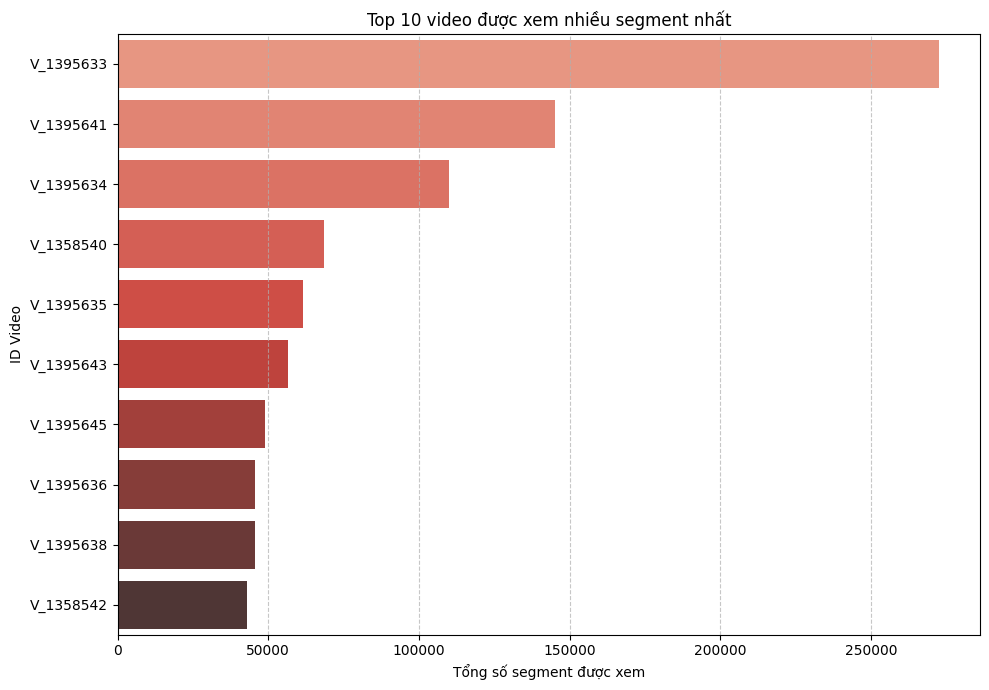

In [33]:
# Tính Top 10 video được xem nhiều segment nhất
top_videos_by_segments_df = final_flat_df.group_by("video_id").agg(
    pl.len().alias("total_segments_viewed")
).sort("total_segments_viewed", descending=True).head(10).to_pandas() # Chuyển sang pandas

plt.figure(figsize=(10, 7))
sns.barplot(x='total_segments_viewed', y='video_id', data=top_videos_by_segments_df, palette='Reds_d')
plt.title("Top 10 video được xem nhiều segment nhất")
plt.xlabel("Tổng số segment được xem")
plt.ylabel("ID Video")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()